In [ ]:
import os
import time
import numpy as np
import cv2
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from IPython.display import clear_output
from scipy.ndimage.filters import gaussian_filter1d   ## smoother

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data.dataset import random_split


from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torchvision.transforms import ToPILImage
from albumentations import *
from sklearn.preprocessing import MinMaxScaler

plt.rcParams['image.cmap'] = 'gray'

In [ ]:
!cp /content/drive/"My Drive"/data/training_data.csv /content/
!cp /content/drive/"My Drive"/zip/frames.zip /content/
!unzip frames.zip 

## Scaling training data

In [ ]:
df = pd.read_csv("training_data.csv")
df.head()

,filenames,A,E,M,P,C,D,Z
0,frames/20091023_dpy-31_3_L2/1.jpg,0,0,0,0,0,0,0
1,frames/20091023_dpy-31_3_L2/2.jpg,2,0,0,0,0,0,0
2,frames/20091023_dpy-31_3_L2/3.jpg,2,0,0,0,0,0,0
3,frames/20091023_dpy-31_3_L2/4.jpg,2,0,0,0,0,0,0
4,frames/20091023_dpy-31_3_L2/5.jpg,3,0,0,0,0,0,0


In [ ]:
data =  df[df.columns[1:]].values

scaler = MinMaxScaler()
print("Scaler = ", scaler.fit(data))
print("Maximum values of each column = ", scaler.data_max_)


Scaler =  MinMaxScaler(copy=True, feature_range=(0, 1))
Maximum values of each column =  [317.  20.  85.   1.  50.  17.   2.]


In [ ]:
new_data = scaler.transform(data)

filenames = df["filenames"]
new_df = pd.DataFrame(new_data)

final_df = pd.concat([filenames, new_df], axis = 1)

final_df.to_csv("scaled_training_data.csv", index = False)
final_df.head()

,filenames,0,1,2,3,4,5,6
0,frames/20091023_dpy-31_3_L2/1.jpg,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,frames/20091023_dpy-31_3_L2/2.jpg,0.006309,0.0,0.0,0.0,0.0,0.0,0.0
2,frames/20091023_dpy-31_3_L2/3.jpg,0.006309,0.0,0.0,0.0,0.0,0.0,0.0
3,frames/20091023_dpy-31_3_L2/4.jpg,0.006309,0.0,0.0,0.0,0.0,0.0,0.0
4,frames/20091023_dpy-31_3_L2/5.jpg,0.009464,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
class ImageDataset(Dataset):   
    def __init__(self, labels_csv_path, augmentation =None, transform = None):
        
        self.df = pd.read_csv(labels_csv_path)
        self.image_paths = self.df.filenames.values
        self.labels = self.df[self.df.columns[1:]].values
        self.transform = transform
        self.augmentation = augmentation
        # self.main_foldername = main_foldername

        # print(self.labels)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        
        image = cv2.imread(path, 0)
        # print(path)
        
        if self.augmentation is not None:
            # print("foo")
            img  = self.augmentation(image = image)
            image = img["image"]
    
        label = torch.Tensor(self.labels[idx]).float()

        return self.transform(image) , label 

    def __len__(self):
        return len(self.image_paths)

In [ ]:
full_dataset = ImageDataset(labels_csv_path = "scaled_training_data.csv",
                         augmentation = Compose([ 
                                                    GridDistortion(p=0.5),
                                                    VerticalFlip(p=0.5),
                                                    HorizontalFlip(p=0.5),
                                                    RandomBrightnessContrast( p=0.5),
                                                    ]),
                            transform = transforms.Compose([    
                                                            transforms.ToPILImage(),
                                                            transforms.Resize((256,256), interpolation = Image.NEAREST),
                                                            torchvision.transforms.RandomAffine(degrees = 10, translate= (0.05, 0.05), scale=None, shear=None, resample=False, fillcolor=0),

                                                            ToTensor(),
                                                            transforms.Normalize(0.5, 0.5, 0.5)
                                                            ])
                             )

In [ ]:

train_size = int(0.8* len(full_dataset))  ## 90/10 split
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)

val_loader = DataLoader(dataset=test_dataset, batch_size= 64, shuffle = True)

print(len(train_loader), "batches ")
print(len(val_loader), " batches ")

196 batches 
196  batches 


In [77]:
def inverse_transform_prediction(output):
    lab = output.numpy().reshape(1,-1) ## convert to 2d np array
    lab = scaler.inverse_transform(lab).flatten() ## back to original domain
    lab = [int(i) for i in lab] ## convert to int 

    return lab

def show_batch(batch):
    fig, ax = plt.subplots(3,3, figsize = (16,12))
    images , labels = batch

    for i in range (9):

        ax.flat[i].imshow(images[i][0])

        lab = inverse_transform_prediction(labels[i])

        ax.flat[i].set_xlabel("label = "+ str(lab), fontsize= 15)


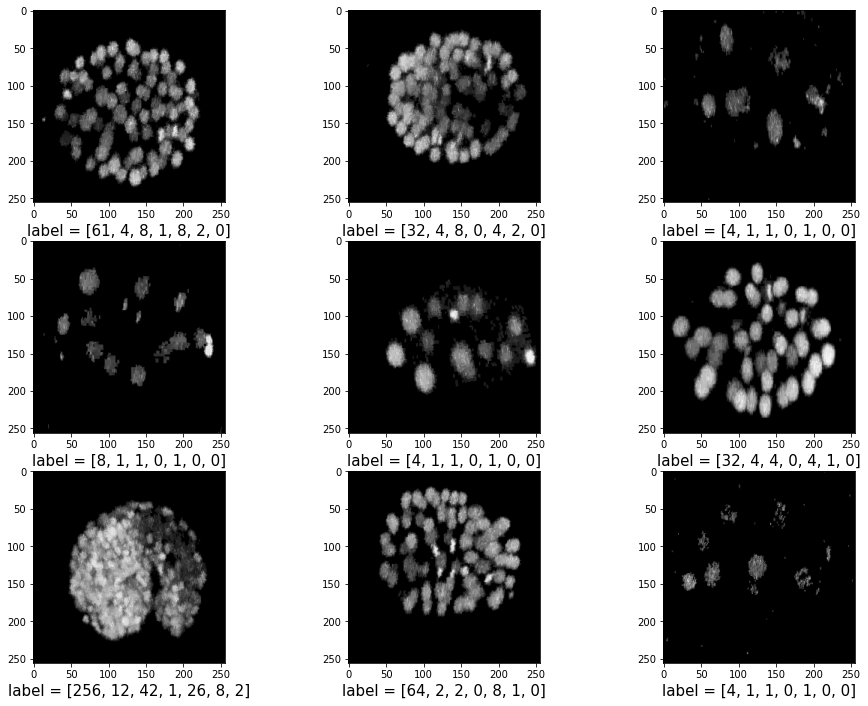

In [81]:
batch = next(iter(train_loader))
show_batch(batch)

In [80]:
def vis_loss_multi(loss_arr,val_arr):
    ysmoothed = gaussian_filter1d(loss_arr, sigma=7)
    plt.plot( ysmoothed, label = "training loss")
    ysmoothed2 = gaussian_filter1d(val_arr, sigma=18)
    plt.plot(ysmoothed2, label = "validation loss")
    plt.show()

def vis_loss_multi_colors(loss_arr,val_arr):
    ysmoothed = gaussian_filter1d(loss_arr, sigma=3)
    plt.plot( ysmoothed, "c", label = "training")
    ysmoothed2 = gaussian_filter1d(val_arr, sigma=7)
    plt.plot(ysmoothed2, "g", label = "validation")
    plt.grid(True)
    plt.ylabel("Loss", fontsize = 15)                                       
    plt.xlabel("batches", fontsize=15)
    plt.legend()
    plt.show()     

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
        
def show_lr(learning_rates):
    plt.plot(learning_rates, label = "learning rate")
    plt.ylabel("Learning rate", fontsize = 15)
    plt.grid(True)
    plt.legend()
    plt.show()

def show_deltas(deltas):
    deltas = gaussian_filter1d(deltas, sigma=3)
    plt.plot(deltas, "r", label = "Absolute error from label ")
    plt.ylabel("Error", fontsize = 15)
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
def train_step(x, y, model, optimizer, criterion):
        optimizer.zero_grad()
        pred = model(x)
        y = y.float()
        loss = criterion(pred,y)
        loss.backward()
        optimizer.step()
        return loss.item()


def train_model(config):

    epochs = config["epochs"]
    model = config["model"]
    train_loder = config["train_loader"]
    val_loader = config["val_loader"]
    lr = config["lr"]
    optimizer = config["optimizer"]
    scheduler = config["scheduler"]
    criterion = config["loss_function"]

    start = time.process_time()
    losses = []
    val_losses = []
    learning_rates = []
    average_deltas = []

    for m in range (epochs):
        clear_output(wait = True)
        vis_loss_multi_colors(losses, val_losses)
        show_lr(learning_rates)
        show_deltas(average_deltas)
        print ("epoch ", m+1, " out of ", epochs )
        
        with torch.no_grad():
            model.eval()

            for x_val, y_val in tqdm(val_loader, desc = "running on test set --"):
                yhat =model(x_val.cuda())  # pred 
                val_loss = criterion(yhat.cuda(), y_val.cuda())
                val_losses.append(val_loss.item())  ## metrics 

                average_deltas.append(torch.mean(torch.abs(yhat.cpu()-y_val.cpu())).item())
        model.train()
       
        for batch in tqdm(train_loader, desc = " Training batches : "):

                (x_batch, y_batch) = batch
                loss = train_step(x_batch.cuda(), y_batch.cuda(), model, optimizer, criterion)
                losses.append(loss)
        scheduler.step(1.)   ## lr decay caller 
        learning_rates.append(get_lr(optimizer))
        

    clear_output(wait = True)

    vis_loss_multi_colors(losses, val_losses)
    show_lr(learning_rates)
    show_deltas(average_deltas)

    print ("Time elapsed = ", time.process_time() - start, " seconds" )
    return losses

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, 5)
        self.pool = nn.MaxPool2d(3, 3)
        self.conv2 = nn.Conv2d(32, 32 , 3)
        self.conv3 = nn.Conv2d(32, 32 , 3)
        self.conv4 = nn.Conv2d(32, 64 , 3)

        self.fc1 = nn.Linear(256,128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 7)
       
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(self.pool(F.relu(self.conv2(x))))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = Net()
model = model.cuda()

optimizer = optim.Adam(model.parameters(), lr = 0.003) 

scheduler = ReduceLROnPlateau(optimizer, 
                                mode='min', 
                                factor=0.5, 
                                patience=3, 
                                verbose=False, 
                                threshold=0.0001, 
                                threshold_mode='rel', 
                                cooldown=0, 
                                min_lr=0, 
                                eps=1e-08)

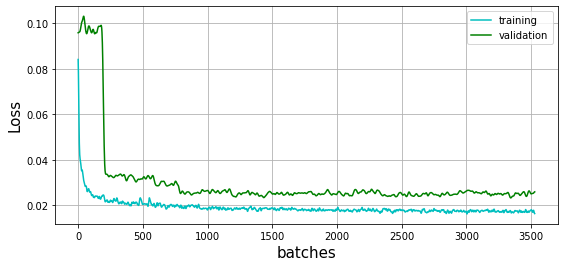

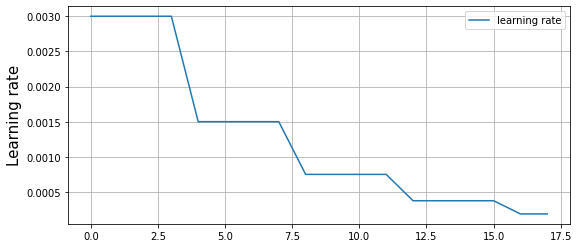

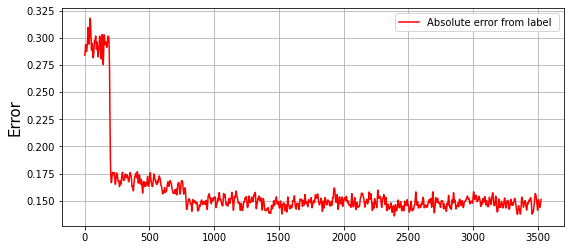

Time elapsed =  9420.240335512999  seconds


In [61]:
plt.rcParams["figure.figsize"] = (9,4)

config = { 
        "epochs" : 18,    
        "model" : model,      
        "train_loader" : train_loader, 
        "val_loader" : val_loader,
        "lr" : 0.001,
        "optimizer" : optimizer,
        "scheduler" : scheduler,
        "loss_function" : nn.SmoothL1Loss()
        }

losses = train_model(config)

In [90]:
def show_preds(model, batch):
    fig, ax = plt.subplots(4,4, figsize = (35,25))

    images , labels = batch
    model.eval()
    preds = model(images.cuda()).cpu().detach()
    # print(preds)

    for i in range (16):
        ax.flat[i].imshow(images[i][0])
        text = "label = "+ str(inverse_transform_prediction(labels[i]))  + "  pred = " + str(inverse_transform_prediction(preds[i]))
        ax.flat[i].set_xlabel(text , fontsize= 17)

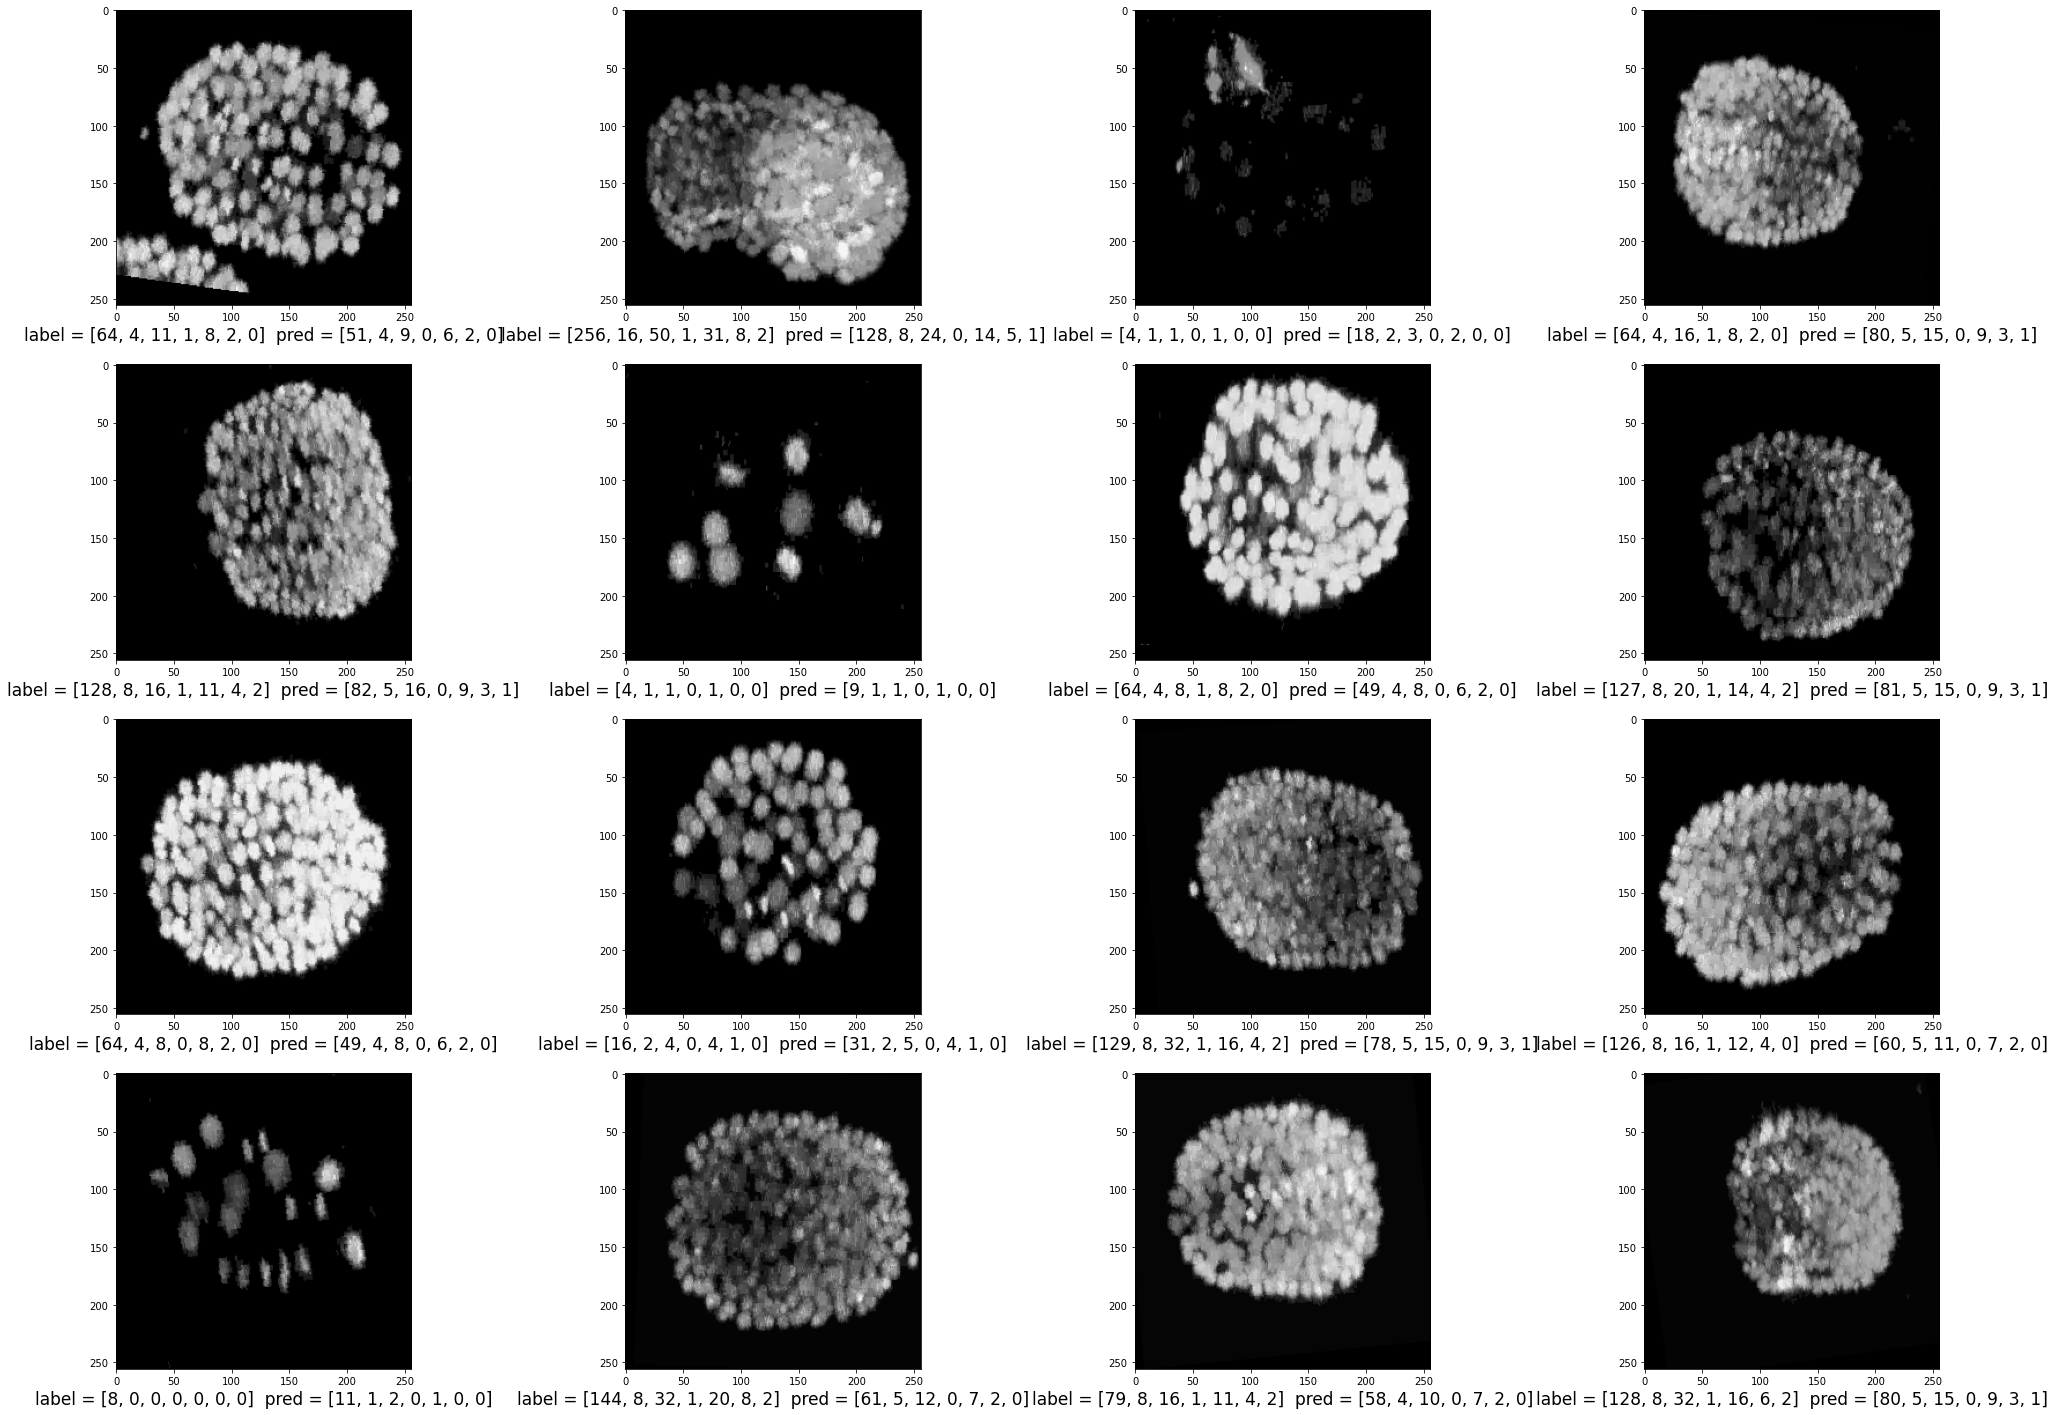

In [91]:
batch = next(iter(val_loader))
show_preds(model , batch)